In [11]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [12]:
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

c:\Users\luisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 1) & 
                                (dados.iloc[:, 7] == 0) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 1) & 
                                (dados.iloc[:, 6] == 0) & 
                                (dados.iloc[:, 7] == 0) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 1) & 
                                (dados.iloc[:, 7] == 0) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 1) & 
                                (dados.iloc[:, 6] == 0) & 
                                (dados.iloc[:, 7] == 0) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 897
Número de linhas ecg_doente_linhas: 1366
Tirando Interferência:
Número de linhas ecg_normal_linhas: 887
Número de linhas ecg_doente_linhas: 1342
Número de ecgs pra clusterizar: 2229


In [14]:
#X

arquivo_hdf5_1 = "../Database/filtered_exams_14_15.hdf5"
arquivo_hdf5_2 = "../Database/filtered_exams_16_17.hdf5"

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in ids_ecgs:
    try:
        tracings = get_ecg_data(arquivo_hdf5_1, exam_id)
    except ValueError:
        tracings = get_ecg_data(arquivo_hdf5_2, exam_id)
    tracing_transposto = np.array(tracings.T)
    all_tracings.append(tracing_transposto)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

print(X)

[[ 7.92574137e-02  6.25308827e-02  4.51568440e-02 ...  7.10911155e-02
   7.32859820e-02  7.06583336e-02]
 [ 3.97443764e-05  2.50804351e-05  1.03194416e-05 ... -1.32796785e-03
  -1.24790578e-03 -1.16564648e-03]
 [-6.63620979e-02 -1.07579879e-01 -1.42677844e-01 ... -1.15685046e-01
  -9.42843258e-02 -6.76577166e-02]
 ...
 [-1.67171925e-03 -1.55077281e-03 -1.42884010e-03 ...  0.00000000e+00
   1.38077467e-05  3.54843032e-05]
 [ 1.10732915e-03  1.09125639e-03  1.07493007e-03 ... -3.14908358e-03
  -2.97320308e-03 -2.79012858e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [15]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(2229, 128, 1)
(2229, 128)


In [22]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=8, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

<>:11: SyntaxWarning: invalid escape sequence '\A'
<>:11: SyntaxWarning: invalid escape sequence '\A'
C:\Users\luisa\AppData\Local\Temp\ipykernel_13456\1413594773.py:11: SyntaxWarning: invalid escape sequence '\A'
  plt.title('ECG Clustering using UMAP and HDBSCAN\AF and Normal')


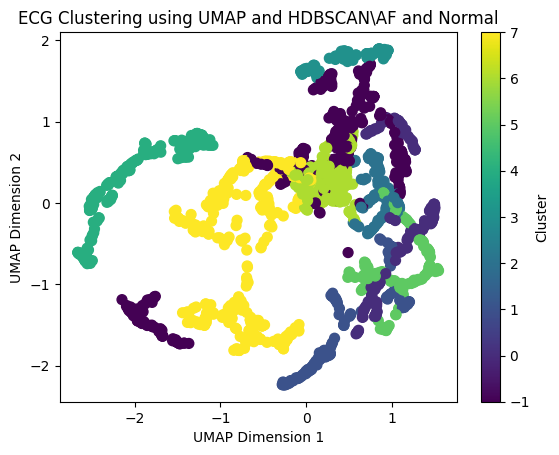

Silhouette Score: 0.3200496435165405
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0       -1      0   278   199   0   0   0           0
1        0      0    88    75   0   0   0           0
2        1      0    96    77   0   0   0           0
3        2      0    75    51   0   0   0           0
4        3      0    99    52   0   0   0           0
5        4      0   125    76   0   0   0           0
6        5      0   104    54   0   0   0           0
7        6      0   271   128   0   0   0           0
8        7      0   206   175   0   0   0           0


In [23]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=100, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\AF and Normal')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

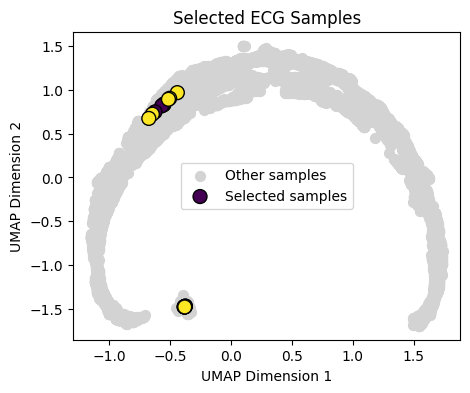

NameError: name 'path_to_file' is not defined

In [ ]:
from sklearn.metrics import silhouette_samples

# Calcular o silhouette score para cada ponto
silhouette_values = silhouette_samples(X_reduced_scaled, labels)

# Criar um DataFrame para armazenar os silhouette scores e labels
silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'label': labels,
    'silhouette_score': silhouette_values
})

# Mesclar os silhouette scores com os metadados dos exames
merged_data = silhouette_df.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('label').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Calcular a quantidade total de ECGs (normais + doentes) em cada cluster
cluster_summary['total'] = cluster_summary[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal_ecg']].sum(axis=1)

# Identificar o cluster majoritariamente doente e o cluster majoritariamente normal
cluster_summary['doente_ratio'] = cluster_summary[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum(axis=1) / cluster_summary['total']
cluster_summary['normal_ratio'] = cluster_summary['normal_ecg'] / cluster_summary['total']

majority_doente_cluster = cluster_summary.loc[cluster_summary['doente_ratio'].idxmax(), 'label']
majority_normal_cluster = cluster_summary.loc[cluster_summary['normal_ratio'].idxmax(), 'label']

def get_top_samples(cluster_label, normal, count=5):
    # Filtrar os dados para o cluster e tipo desejado (normal/doente)
    if normal:
        samples = merged_data[(merged_data['label'] == cluster_label) & (merged_data['normal_ecg'] == 1)]
    else:
        samples = merged_data[(merged_data['label'] == cluster_label) & (merged_data['normal_ecg'] == 0)]
    
    # Ordenar por silhouette score (do maior para o menor)
    samples = samples.sort_values(by='silhouette_score', ascending=False)
    
    # Selecionar as top `count` amostras
    top_samples = samples.head(count)
    
    return top_samples

# Obter as amostras desejadas
top_5_normals_majority_doente = get_top_samples(majority_doente_cluster, normal=True)
top_5_doentes_majority_doente = get_top_samples(majority_doente_cluster, normal=False)
top_5_normals_majority_normal = get_top_samples(majority_normal_cluster, normal=True)
top_5_doentes_majority_normal = get_top_samples(majority_normal_cluster, normal=False)

def plot_samples(X, sample_indices, labels, title):
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=50, label='Other samples')
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], c=labels, s=100, edgecolor='k', label='Selected samples')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Obter os índices das amostras selecionadas
sample_indices = pd.concat([
    top_5_normals_majority_doente,
    top_5_doentes_majority_doente,
    top_5_normals_majority_normal,
    top_5_doentes_majority_normal
])['exam_id'].values

# Mapear os IDs de exames para os índices no X_reduced_scaled
exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
selected_indices = [exam_id_to_index[exam_id] for exam_id in sample_indices]

# Definir labels coloridos para as amostras selecionadas (1 para normais, 2 para doentes)
labels = [1 if exam_id in top_5_normals_majority_doente['exam_id'].values or exam_id in top_5_normals_majority_normal['exam_id'].values else 2 for exam_id in sample_indices]

# Plotar as amostras
plot_samples(X_reduced_scaled, selected_indices, labels, 'Selected ECG Samples')

import h5py
import numpy as np
import ecg_plot
import matplotlib.pyplot as plt
import pandas as pd
import os

# Função para plotar e salvar ECGs em pastas específicas
def plot_and_save_ecg(exam_ids_to_plot, labels, path_to_file, output_dir='resultados'):
    # Definir subdiretórios
    subdirs = {
        'normais-clusterDoente': [],
        'doentes-clusterDoente': [],
        'normais-clusterNormal': [],
        'doentes-clusterNormal': []
    }

    # Abrir o arquivo HDF5
    with h5py.File(path_to_file, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        for exam_id_to_plot, label in zip(exam_ids_to_plot, labels):
            # Determinar o subdiretório com base no rótulo
            if label == 'normais-clusterDoente':
                subdir = 'normais-clusterDoente'
            elif label == 'doentes-clusterDoente':
                subdir = 'doentes-clusterDoente'
            elif label == 'normais-clusterNormal':
                subdir = 'normais-clusterNormal'
            elif label == 'doentes-clusterNormal':
                subdir = 'doentes-clusterNormal'
            else:
                continue

            # Adicionar exam_id ao subdiretório correspondente
            subdirs[subdir].append(exam_id_to_plot)

        # Criar diretórios de saída se não existirem
        for subdir in subdirs.keys():
            full_path = os.path.join(output_dir, subdir)
            if not os.path.exists(full_path):
                os.makedirs(full_path)

        for subdir, ids in subdirs.items():
            for exam_id_to_plot in ids:
                # Encontrar o índice correspondente ao exam_id de interesse
                exam_index = np.where(exam_ids == exam_id_to_plot)[0]

                if len(exam_index) == 0:
                    print(f"Exam ID {exam_id_to_plot} não encontrado.")
                else:
                    exam_index = exam_index[0]

                    # Acessar os tracings de ECG correspondentes ao exam_index
                    exam_tracings = f['tracings'][exam_index]

                    # Converter exam_tracings em um array NumPy
                    ecg = np.array(exam_tracings).T
                    # Verificar as dimensões do array ecg
                    print(f"Dimensões do ECG para exam_id {exam_id_to_plot}: {ecg.shape}")

                    # Plotar o ECG
                    ecg_plot.plot(ecg, sample_rate=400, title=f'ECG {exam_id_to_plot}', row_height=30)
                    plt.savefig(f'{output_dir}/{subdir}/ecg_{exam_id_to_plot}.png', dpi=300)  # Nome do arquivo com o ID
                    plt.close()  # Fecha a figura para liberar memória

# Função auxiliar para obter os rótulos das amostras
def get_sample_labels():
    labels = []
    for _, row in top_5_normals_majority_doente.iterrows():
        labels.append('normais-clusterDoente')
    for _, row in top_5_doentes_majority_doente.iterrows():
        labels.append('doentes-clusterDoente')
    for _, row in top_5_normals_majority_normal.iterrows():
        labels.append('normais-clusterNormal')
    for _, row in top_5_doentes_majority_normal.iterrows():
        labels.append('doentes-clusterNormal')
    return labels

# IDs das amostras selecionadas e seus rótulos
sample_indices = pd.concat([
    top_5_normals_majority_doente,
    top_5_doentes_majority_doente,
    top_5_normals_majority_normal,
    top_5_doentes_majority_normal
])['exam_id'].values

sample_labels = get_sample_labels()

# Plotar e salvar os sinais de ECG
plot_and_save_ecg(sample_indices, sample_labels, path_to_file)